In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.segmentation import quickshift
from PIL import Image

%matplotlib notebook

In [11]:
# попытка подключить osgeo через PIP или с инсталлятора
#!pip install gdal # не работает через стандартный репозиторий

# !set PATH=%PATH%;C:\OSGeo4W64\bin 
#!set path = %PYTHONPATH%;C:\OSGeo4W64\share\gdal;C:\OSGeo4W64\apps\Python37\lib\site-packages
#!set GDAL_DATA = C:\OSGeo4W64\share\gdal
#!set GDAL_LIBRARY_PATH = C:\OSGeo4W64\bin\gdal204
#!set OSGEO4W_ROOT=C:\OSGeo4W64

In [12]:
# в итоге для запуска на Win10 пришлось ставить из неофициальных бинарных сборок с
# с https://www.lfd.uci.edu/~gohlke/pythonlibs/

# !pip install GDAL-2.4.1-cp37-cp37m-win_amd64.whl # закачать и раскомментировать при запуске в первый раз
# !pip install Fiona-1.8.6-cp37-cp37m-win_amd64.whl # закачать и раскомментировать при запуске в первый раз
# !pip install rasterio-1.0.22-cp37-cp37m-win_amd64.whl # закачать и раскомментировать при запуске в первый раз
# !pip install Cartopy-0.17.0-cp37-cp37m-win_amd64.whl # закачать и раскомментировать при запуске в первый раз

In [13]:
import sys
# sys.path.append('C:/OSGeo4W64/apps/Python37/lib/site-packages')
# sys.path.append('C:/OSGeo4W64/bin')
# sys.path.append('C:/OSGeo4W64/share/gdal')
#import osgeo
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from osgeo import gdal_array
from osgeo import gdalconst

# Загрузка изображения
http://geoinformaticstutorial.blogspot.com/2016/02/k-means-clustering-of-satellite-images.html

In [14]:
filename = "CIR_531.tif"
ds = gdal.Open(filename, gdalconst.GA_ReadOnly)

sarraster = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()
inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)

# проверка корректности загрузки, информация о файле
print(proj)
print(ds.RasterXSize)
print(ds.RasterYSize)
print(ds.RasterCount)
print(sarraster.shape)

ds = None # для экономии памяти

# изменение формата с [3, y, x] на [y, x, 3]

# sarraster2 = np.stack((sarraster[0,1000:11000,1000:15000],
#                        sarraster[1,1000:11000,1000:15000],
#                        sarraster[2,1000:11000,1000:15000]),axis=2)
sarraster2 = np.rollaxis(sarraster[:,1000:11000,1000:15000],0,3)
sarraster = None # для экономии памяти

PROJCS["WGS 84 / UTM zone 37N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",39],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32637"]]
29327
18211
3
(3, 18211, 29327)


## Визуализация с Matplotlib

(10000, 14000, 3)


<IPython.core.display.Javascript object>


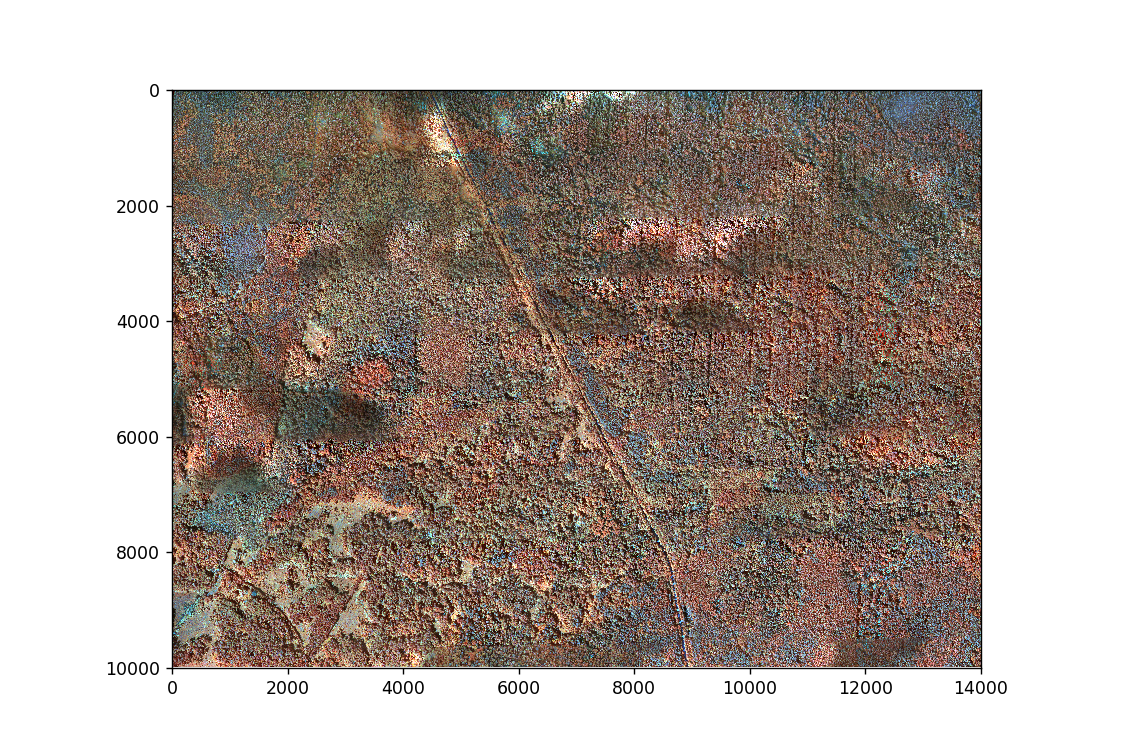

In [19]:
print(sarraster2.shape)
plt.figure(figsize=(9,6))
plt.imshow(sarraster2)    
plt.show()

## -GDAL

In [20]:
# эта визуализация не доведена

# srcband = ds.GetRasterBand(0)
# dst_layername = "POLYGONIZED_STUFF"
# drv = ogr.GetDriverByName("ESRI Shapefile")
# dst_ds = drv.CreateDataSource( dst_layername + ".shp" )
# dst_layer = dst_ds.CreateLayer(dst_layername, srs = None )
# gdal.Polygonize( srcband, None, dst_layer, -1, [], callback=None )

## -Cartopy

In [21]:
# эта визуализация не доведена

# !pip install geos # раскомментировать при запуске в первый раз
# !pip install proj # раскомментировать при запуске в первый раз
# import cartopy.crs as ccrs

# projcs = inproj.GetAuthorityCode('PROJCS')
# projection = ccrs.epsg(projcs)
# print(projection)

## +Rasterio

<IPython.core.display.Javascript object>


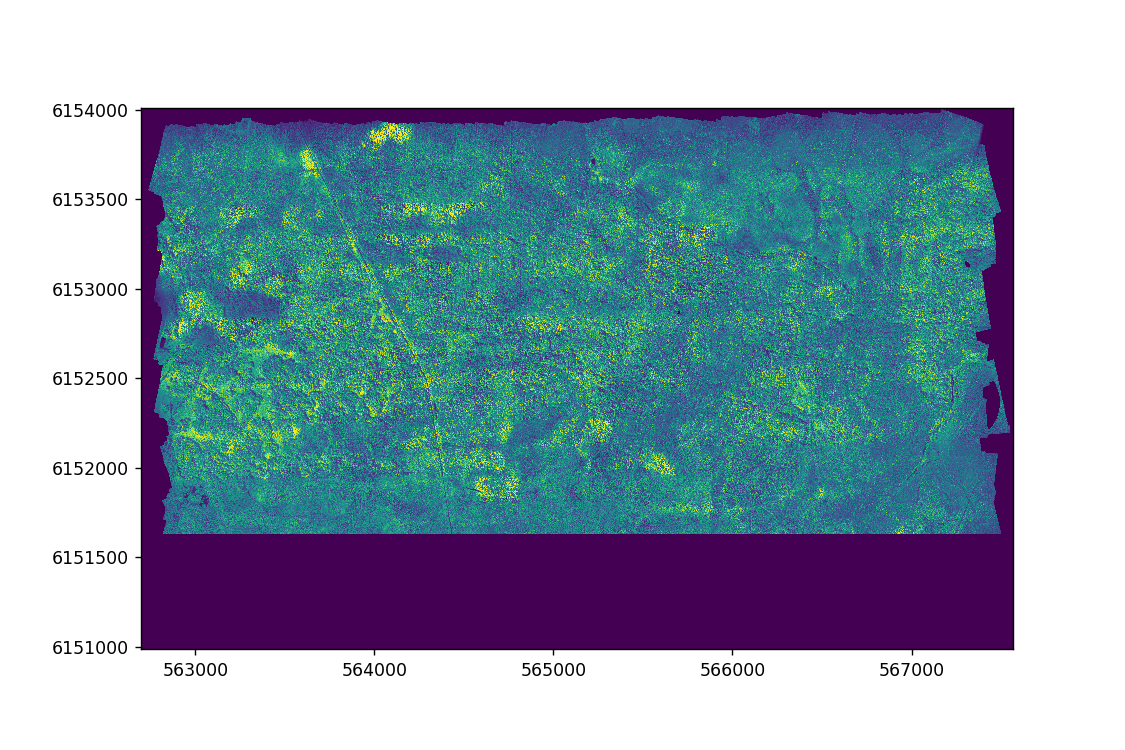

In [22]:
import rasterio
from rasterio.plot import show

ds2 = rasterio.open('CIR_531.tif')
fig2 = plt.figure(figsize=(9,6))
show(ds2)
ds2 = None

## -IPython.core.display.Image

In [23]:
# не работает, крашит весь ноутбук

# from IPython.core.display import Image, display
# import IPython.core.display as IPy
# IPython.display.display(IPy.Image(sarraster2[0:1000,0:1000,:], width=100, unconfined=True))

## -PIL

In [24]:
# не доведено
# import PIL
# import IPython

# pil_im = PIL.Image.fromarray(sarraster2) 
# IPython.display(pil_im)

# Пороговая фильтрация

<IPython.core.display.Javascript object>


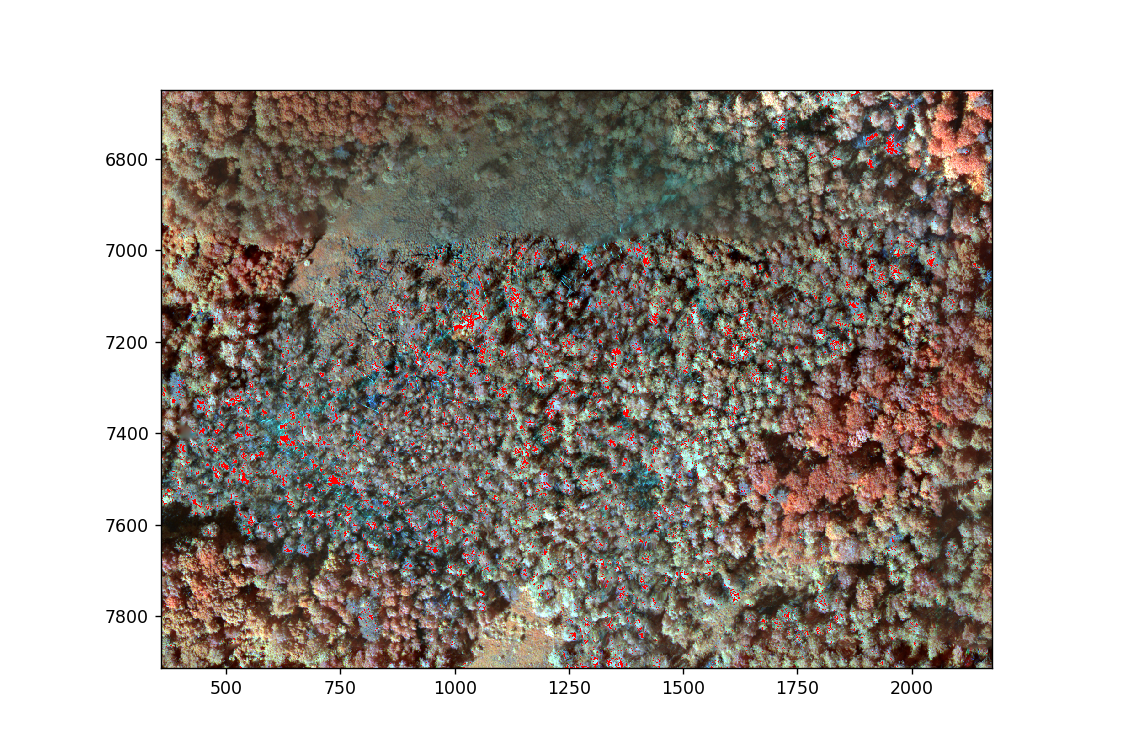

In [25]:
lower_blue = np.array([90,180,180]) # RGB
upper_blue = np.array([150,255,255]) # RGB
mask_orig = cv2.inRange(sarraster2, lower_blue, upper_blue)
mask_inv = cv2.bitwise_not(mask_orig)

redImg = np.zeros((mask_orig.shape[0], mask_orig.shape[1], 3), mask_orig.dtype)
redImg[:,:] = (255, 0, 0)
redMask = cv2.bitwise_and(redImg, redImg, mask=mask_orig)
sarraster3 = cv2.bitwise_and(sarraster2, sarraster2, mask=mask_inv)
# https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html
# sarraster3 = cv2.addWeighted(redMask, 1, sarraster2, 0, 0.0, sarraster2)

# sarraster3 = np.copy(sarraster2)
# sarraster3[mask_orig] = (0, 0, 255)
plt.figure(figsize=(9,6))
plt.imshow(cv2.add(sarraster3,redMask))
#plt.imshow(redMask)
plt.show()
redImg = None
redMask = None
sarraster3 = None
mask_inv = None

# Морфология

In [26]:
# mask_morph = cv2.erode(mask_orig, None, iterations=1) # убрать однопиксельные включения, число итераций подбирается
# mask_morph = cv2.dilate(mask_morph, None, iterations=3) # число итераций подбирается


## Оконтуривание (простое)

In [27]:
# mask2=np.copy(mask)
# contours, hierarchy = cv2.findContours(mask2,
#                                         cv2.RETR_TREE,#cv2.RETR_EXTERNAL,#
#                                         cv2.CHAIN_APPROX_SIMPLE)
# sarraster3=np.copy(sarraster2)

# cv2.drawContours( sarraster3, contours, -1, (0,0,255),
#                  3, cv2.LINE_AA, hierarchy, 1 )
# fig3 = plt.figure(figsize=(9,9))
# cv2.drawContours(sarraster3, contours, -1, (255,0, 0), 50)
# plt.imshow(sarraster3)  
# plt.show()
# sarraster3 = None

# Кластеризация

In [29]:
# проверки размерностей и параметров
print(mask_orig[2][2])
nonzero_points=np.nonzero(mask_orig)
print(len(nonzero_points[1])) #([i,i,i],[j,j,j],[k,k,k])
print(mask_orig.shape)
point_cloud= np.vstack((nonzero_points[0],nonzero_points[1])).transpose()
print(point_cloud.shape)

0
1130437
(10000, 14000)
(1130437, 2)


## -HDBScan
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

In [30]:
# кластеризация с hdbscan, не доведена до приемлемых результатов, очень медленно работает
import seaborn as sns
import sklearn.cluster as cluster
import hdbscan
import time

#!pip install seaborn # раскомментировать при запуске в первый раз
#!pip install hdbscan # раскомментировать при запуске в первый раз

# def plot_clusters(data, algorithm, args, kwds):
#     #start_time = time.time()
#     labels = algorithm(*args, **kwds).fit_predict(data)
#     print(labels)
#     #end_time = time.time()
#     palette = sns.color_palette('deep', np.unique(labels).max() + 1)
#     colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
#     plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
#     plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
#     frame = plt.gca()
#     frame.axes.get_xaxis().set_visible(False)
#     frame.axes.get_yaxis().set_visible(False)
#     plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
#     #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    
# plot_clusters(point_cloud, hdbscan.HDBSCAN, (), {'min_cluster_size':15})

## DBSCAN (sklearn.cluster)

In [30]:
# from sklearn.preprocessing import StandardScaler
# point_cloud_fit = StandardScaler().fit_transform(point_cloud)

c:\python37\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\python37\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [35]:
from sklearn.cluster import DBSCAN
# подбор eps и min_samples
# clustering = DBSCAN(eps=50, min_samples=100).fit(point_cloud)
# labels = clustering.labels_
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)
# print(n_clusters_)
# print(n_noise_)

794
178335


In [36]:
from sklearn.cluster import DBSCAN
# подбор eps и min_samples
clustering = DBSCAN(eps=100, min_samples=500).fit(point_cloud)
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print(n_clusters_)
print(n_noise_)

167
265365


In [37]:
# диагностическая печать

labels = clustering.labels_
print(len(set(labels))-(1 if -1 in labels else 0))
#points_filtered = point_cloud[df.tweet_cluster_labels>-1]
print(point_cloud.shape)

core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print(n_clusters_)
print(n_noise_)

167
(1130437, 2)
167
265365


In [38]:
# черновик

# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each)
#           for each in np.linspace(0, 1, len(unique_labels))]
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = (labels == k)

#     xy = point_cloud[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14)

#     xy = point_cloud[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=6)

# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

<IPython.core.display.Javascript object>


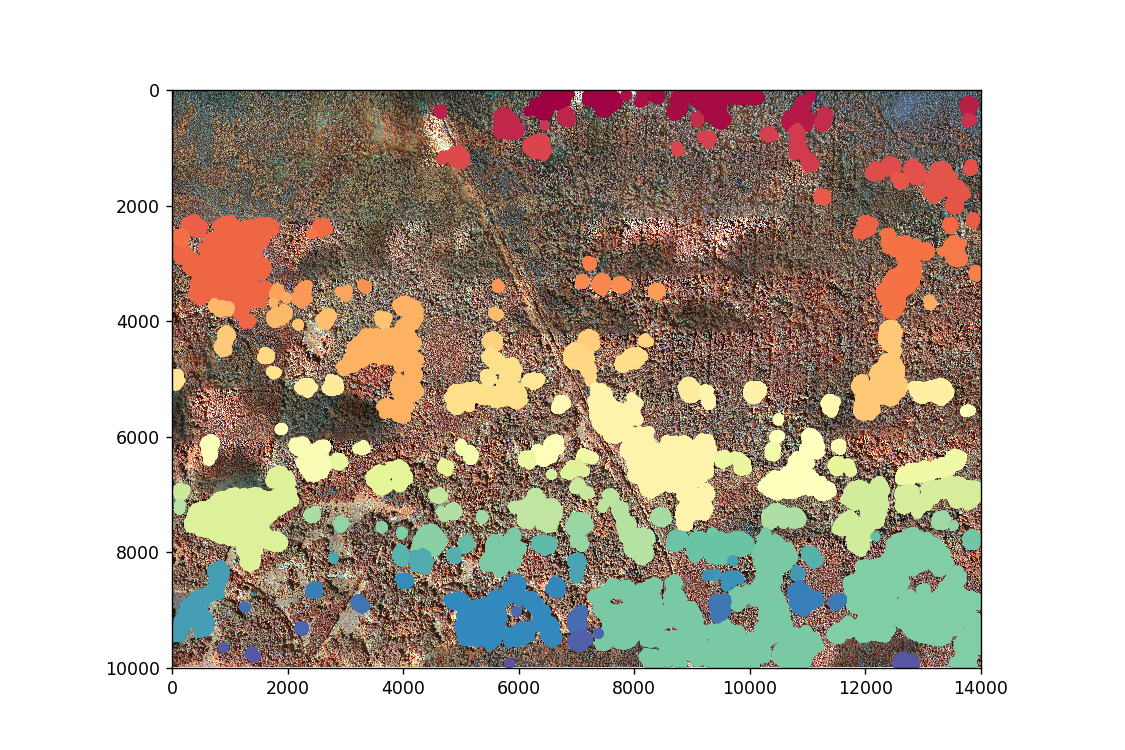

In [42]:
fig = plt.figure(figsize=(9,6))
plt.imshow(sarraster2)

unique_labels = set(labels) # отсев повторяющихся 
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = point_cloud[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor=col, markersize=5)

#     xy = point_cloud[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='cyan', markersize=1)

plt.show()

# Оконтуривание кластеров
https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.spatial.ConvexHull.html

In [ ]:
from scipy.spatial import ConvexHull
# разбить по label-ам
allPoints=np.column_stack((LATS,LONGS))
# оконтурить
hullPoints = ConvexHull(allPoints)

In [ ]:
# поискать также bounary extrac

# Запись GeoJSON

# Визуализация с  GeoJSON